# Pipeline Clustering Verfahren

# Inhaltsverzeichnis
1. [Daten einlesen](#introduction)
    1. [Daten aussuchen](#subparagraph1)
    2. [Daten vorbereiten](#subparagraph3)
2. [K-Means](#paragraph1)
    1. [PCA davor](#subparagraph2.1)
    2. [PCA danach](#subparagraph2.2)
3. [Hierarchical Clustering](#paragraph2)
    1. [nicht reduziert](#subparagraph3.1)
    2. [reduziert](#subparagraph3.2)
4. [Gaussian Mixture Model](#paragraph3)
5. [Bayes Mixture Model](#paragraph4)

### Daten einlesen <a name="introduction"></a>

In [58]:
import pandas as pd
import numpy as np
from copy import deepcopy
from matplotlib import pyplot as plt
%matplotlib inline
import itertools
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import make_blobs
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import squareform
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn import manifold
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture 
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from yellowbrick.text import TSNEVisualizer, UMAPVisualizer

In [17]:
df = pd.read_csv("../datasets/currently_dataset/song_decades_long.csv", index_col=[0])

In [18]:
# df.drop(['genre1'], inplace=True, axis = 1)

In [19]:
df.head()

,artist,decades,text,stemmed_text,POS,Genre1,genre1,number_of_tokens,number_of_types
0,"""Weird Al"" Yankovic",1980s,potato skins potato cakes hash browns and i...,potato skin potato cake hash brown and instan...,french plain enough greasy sour lumpy tough en...,Rock,antiviral pop,12745.0,2264.0
37,"""Weird Al"" Yankovic",1990s,as i walk through the valley where i harvest m...,as i walk through the valley where i harvest ...,plain perfect fancy amish amish hard amish ami...,Rock,antiviral pop,10803.0,2317.0
65,"""Weird Al"" Yankovic",2000s,jillian was her name she was sweeter than asp...,jillian wa her name she wa sweeter than aspar...,same gorgeous perfect close sweet young ripe p...,Rock,antiviral pop,4352.0,1159.0
76,"""Weird Al"" Yankovic",2010s,my mama told me when i was hatched act like a...,my mama told me when i wa hatch act like a su...,red hard sure swiss crazy little okay crazy ev...,Rock,antiviral pop,2077.0,705.0
81,*NSYNC,1990s,here we go here we go one more time eve...,here we go here we go one more time everybodi...,fine fine free right fine right fine free time...,Electronic,boy band,1786.0,345.0


In [20]:
df = df.replace(np.nan, '', regex=True)

In [7]:
df_num = df.select_dtypes(include=[np.number])

In [10]:
# df.genre1.tolist()

spezielle Daten auswählen <a name="subparagraph1"></a>

In [21]:
rock = df[df['Genre1'] == 'Rock']
pop = df[df['Genre1'] == 'Pop']

In [24]:
jazz = df[df['Genre1'] == 'Jazz']
hiphop = df[df['Genre1'] == 'Hip Hop']
electro = df[df['Genre1'] == 'Electronic']
country = df[df['Genre1'] == 'Folk, World, & Country']
fourgenres = pd.concat([jazz, hiphop, electro, country], axis = 0)

In [25]:
data1 = df[df['artist'] == 'Katy Perry']
data2 = df[df['artist'] == 'Olly Murs']
popartist = pd.concat([data1, data2], axis = 0)

In [26]:
data1 = df[df['artist'] == 'Eminem']
data2 = df[df['artist'] == 'ABBA']
mixedartist = pd.concat([data1, data2], axis = 0)

In [27]:
ohnerock = df[df.Genre1!='Rock']
ohnerockpop = ohnerock[ohnerock.Genre1!='Pop']

In [29]:
alternative = df[df.genre1=='alternative rock']
dance = df[df.genre1=='dance pop']
alt_danc = pd.concat([alternative, dance], axis = 0)

In [9]:
twothousands = data[data.decades=='2000s']

Daten vorbereiten <a name="subparagraph3"></a>

In [30]:
def tfidf(data):
    tf_idf_vectorizor = TfidfVectorizer()
    tf_idf = tf_idf_vectorizor.fit_transform(data)
    tf_idf_norm = normalize(tf_idf)
    tf_idf_array = tf_idf_norm.toarray()
    return tf_idf_array

In [80]:
def compute_PCA(text):
    pca = PCA(n_components = 2)
    Y = pca.fit_transform(text)
    return Y

In [48]:
def visualise_PCA(Y, hue, style, title, path=None):
    markers = ('o', 'v', '^', '<', '>', 's', 'p','8', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v', '^')
    plt.figure(figsize=(15,10))
    sns.scatterplot(Y[:, 0], Y[:, 1],hue=hue, style=style, markers=markers, palette=sns.color_palette("hls", len(np.unique(hue))))
    plt.title(title)
    if path is not None:
        plt.savefig(path, bbox_inches = "tight")

In [85]:
def visualise_TSNE(Y, hue, style, title, perplexity=50, path=None):
    X_reduced = TruncatedSVD(n_components=10, random_state=0).fit_transform(tf_idf_array)
    X_embedded = TSNE(n_components=2, perplexity=perplexity, n_iter=1000,learning_rate=10, verbose=2).fit_transform(X_reduced)
        
    markers = ('o', 'v', '^', 's', 'p', '*','d', 'P', 'X')
    plt.figure(figsize=(15,10))
    sns.set_style("white")
    sns.scatterplot(X_embedded[:, 0], X_embedded[:, 1],hue=hue, style=style, markers=markers, palette=sns.color_palette("hls", len(np.unique(hue))))
    plt.title(title)
    if path is not None:
        plt.savefig(path, bbox_inches = "tight")

In [75]:
def visualise_UMAP(docs, labels, title, path=None):

    umap = UMAPVisualizer(metric='cosine')
    plt.figure(figsize=(15,10))
    umap.fit(docs, labels)
    if path is not None:
        plt.savefig(path, bbox_inches = "tight")
    umap.show()

## K-Means <a name="paragraph2"></a>

PCA davor <a name="subparagraph2.1"></a>

In [46]:
tf_idf_array = tfidf(fourgenres.text)

In [81]:
Y = compute_PCA(tf_idf_array)
kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y)
prediction = kmeans.predict(Y)

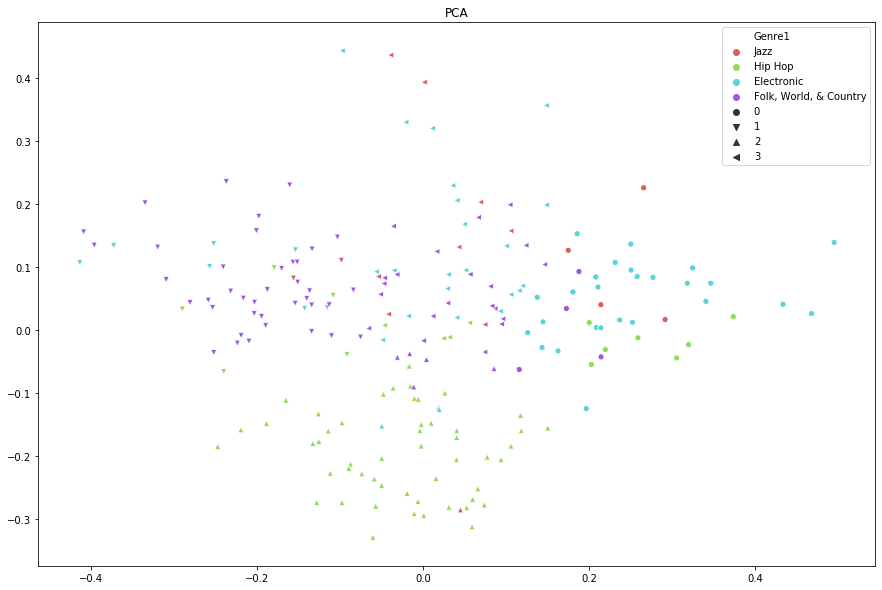

In [53]:
visualise_PCA(Y_sklearn, fourgenres.Genre1, prediction, 'PCA')

PCA danach <a name="subparagraph2.2"></a>

In [54]:
kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(tf_idf_array)
prediction = kmeans.predict(tf_idf_array)

Y = compute_PCA(tf_idf_array)

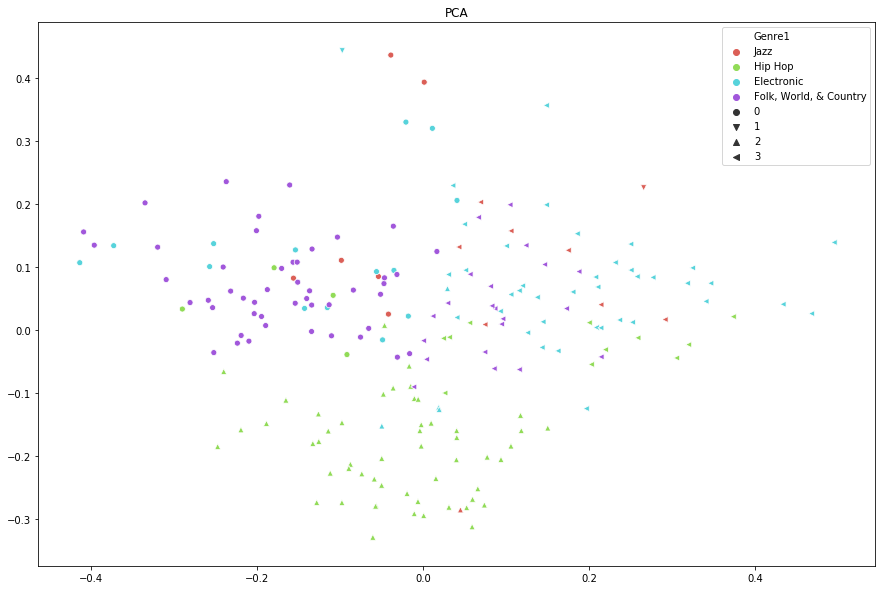

In [56]:
visualise_PCA(Y, fourgenres.Genre1, prediction,'PCA','tsne-kmeans/K-Means_Pop_Rock_2000_PCA.png')

### T-SNE danach

In [59]:
kmeans = KMeans(n_clusters=4, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(tf_idf_array)
prediction = kmeans.predict(tf_idf_array)

In [60]:
X_reduced = TruncatedSVD(n_components=10, random_state=0).fit_transform(tf_idf_array)

In [62]:
# perplexity = [5, 10, 20, 30, 40, 50, 60 ,80,100]
perplexity = [50]
for p in perplexity:
    X_embedded = TSNE(n_components=2, perplexity=p, n_iter=1000,learning_rate=10, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 209 samples in 0.000s...
[t-SNE] Computed neighbors for 209 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 209 / 209
[t-SNE] Mean sigma: 0.170580
[t-SNE] Computed conditional probabilities in 0.026s
[t-SNE] Iteration 50: error = 45.4676056, gradient norm = 0.0000000 (50 iterations in 0.129s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 45.467606
[t-SNE] Iteration 100: error = 0.4530642, gradient norm = 0.0052779 (50 iterations in 0.046s)
[t-SNE] Iteration 150: error = 0.4275522, gradient norm = 0.0009810 (50 iterations in 0.053s)
[t-SNE] Iteration 200: error = 0.4248292, gradient norm = 0.0006645 (50 iterations in 0.035s)
[t-SNE] Iteration 250: error = 0.4241956, gradient norm = 0.0001379 (50 iterations in 0.037s)
[t-SNE] Iteration 300: error = 0.4242162, gradient norm = 0.0000782 (50 iterations in 0.035s)
[t-SNE] Iteration

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 209 samples in 0.000s...
[t-SNE] Computed neighbors for 209 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 209 / 209
[t-SNE] Mean sigma: 0.170580
[t-SNE] Computed conditional probabilities in 0.039s
[t-SNE] Iteration 50: error = 45.4676132, gradient norm = 0.0000000 (50 iterations in 0.151s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 45.467613
[t-SNE] Iteration 100: error = 0.4562091, gradient norm = 0.0055773 (50 iterations in 0.063s)
[t-SNE] Iteration 150: error = 0.4336484, gradient norm = 0.0004198 (50 iterations in 0.037s)
[t-SNE] Iteration 200: error = 0.4323565, gradient norm = 0.0002672 (50 iterations in 0.037s)
[t-SNE] Iteration 250: error = 0.4291766, gradient norm = 0.0006448 (50 iterations in 0.037s)
[t-SNE] Iteration 300: error = 0.4224218, gradient norm = 0.0004413 (50 iterations in 0.055s)
[t-SNE] Iteration

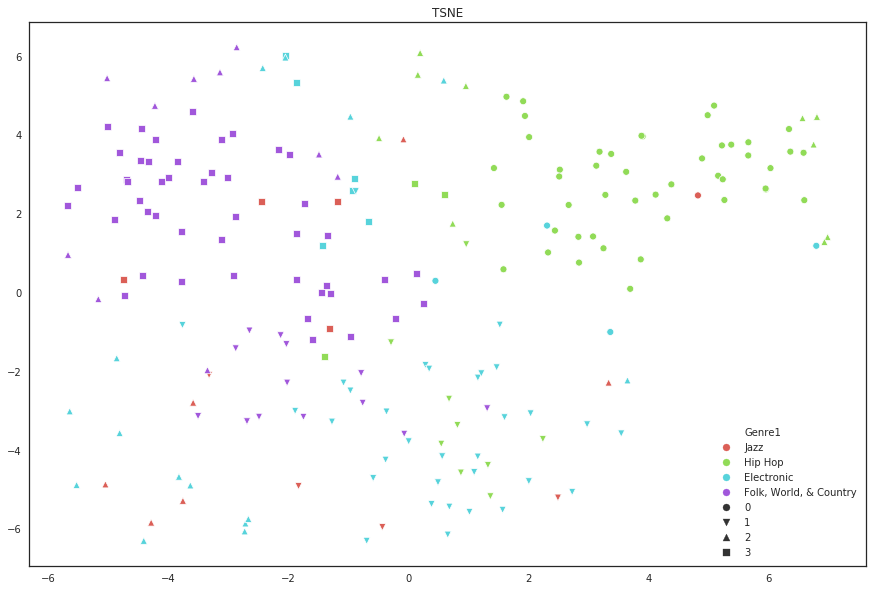

In [87]:
visualise_TSNE(tf_idf_array, fourgenres.Genre1, prediction,'TSNE', perplexity=50, 'tsne-kmeans/kmeans_tsne_Pop_Rock_2000.png')

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

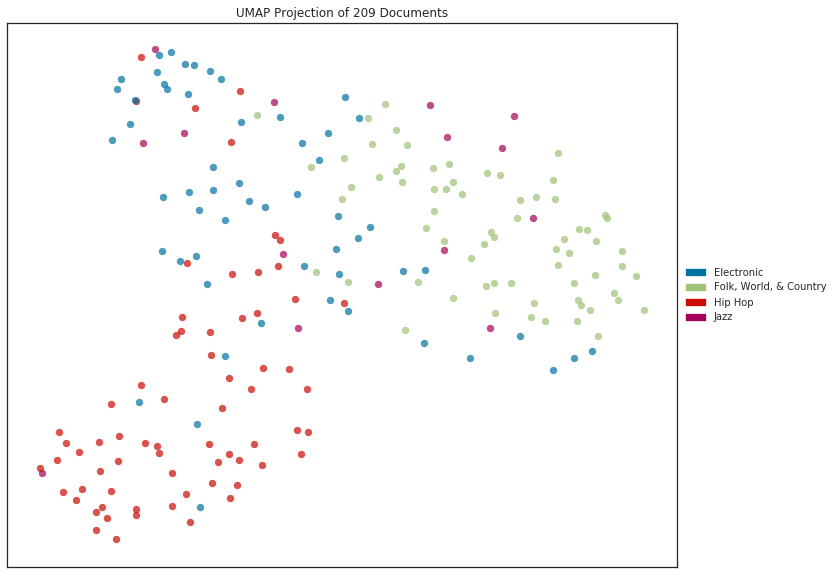

In [76]:
visualise_UMAP(tf_idf_array, fourgenres.Genre1, 'UMAP')

## HC <a name="paragraph2"></a>

In [77]:
def linkage_matrix(n_samples, children, distances):
    """
    create a linkage matrix for the dendogram method in scipy
    n_samples: int, number of samples
    children: list of lists, clustered data points (should be 2)
    distances: list of distances between nodes
    """
    # Create linkage matrix
    

    # create the counts of samples under each node
    counts = np.zeros(children.shape[0])
    for i, merge in enumerate(children):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack([children, distances, counts]).astype(float)

nicht reduziert <a name="subparagraph3.1"></a>

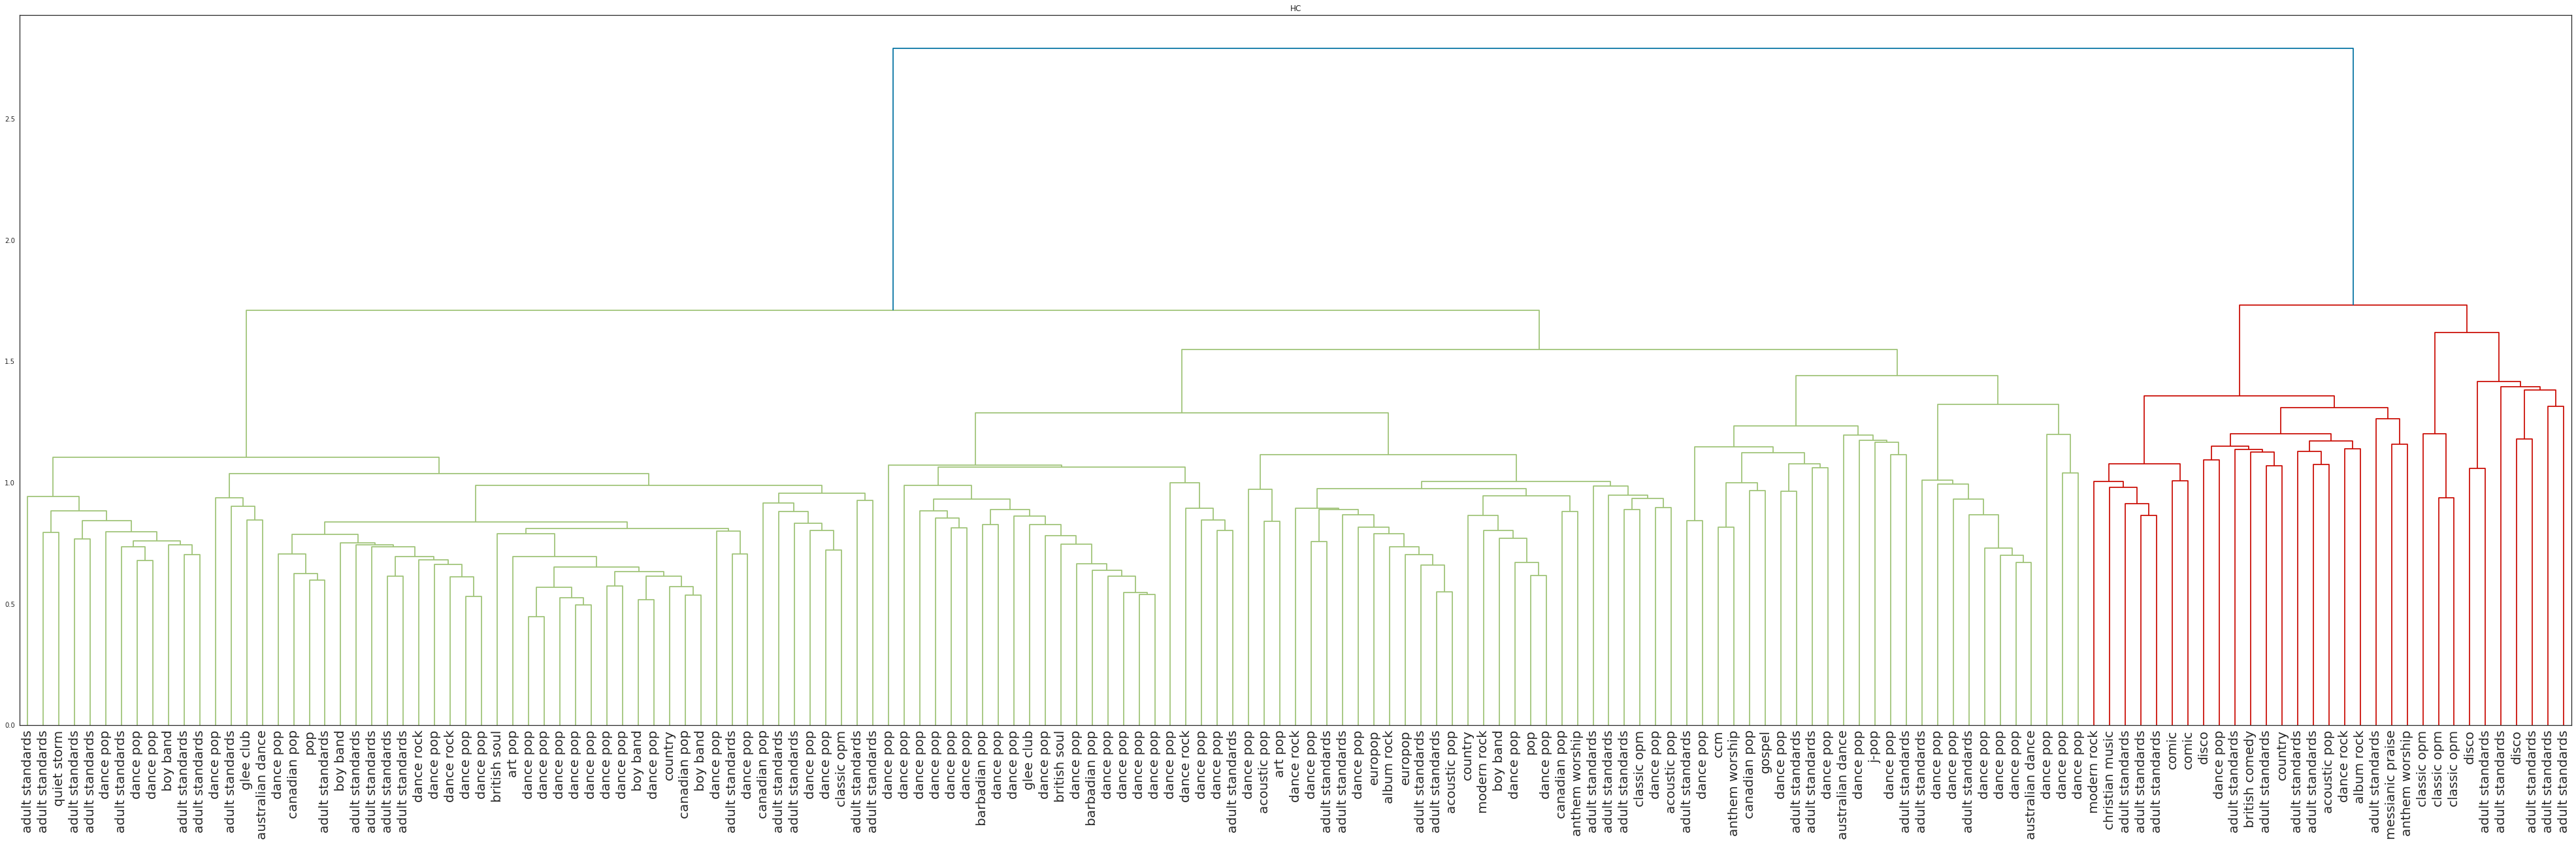

In [76]:
model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(tf_idf_array)
link_matrix = linkage_matrix(tf_idf_array.shape[0], model.children_, model.distances_)
plt.figure(figsize=(70,20))
plt.title('HC')
dendrogram(link_matrix, labels = (pop.genre1.values), leaf_font_size=20);
plt.savefig('../images/Bilder_Abschlusspräsi/HC_Pop_genre1.png', bbox_inches = "tight")

reduziert <a name="subparagraph3.2"></a>

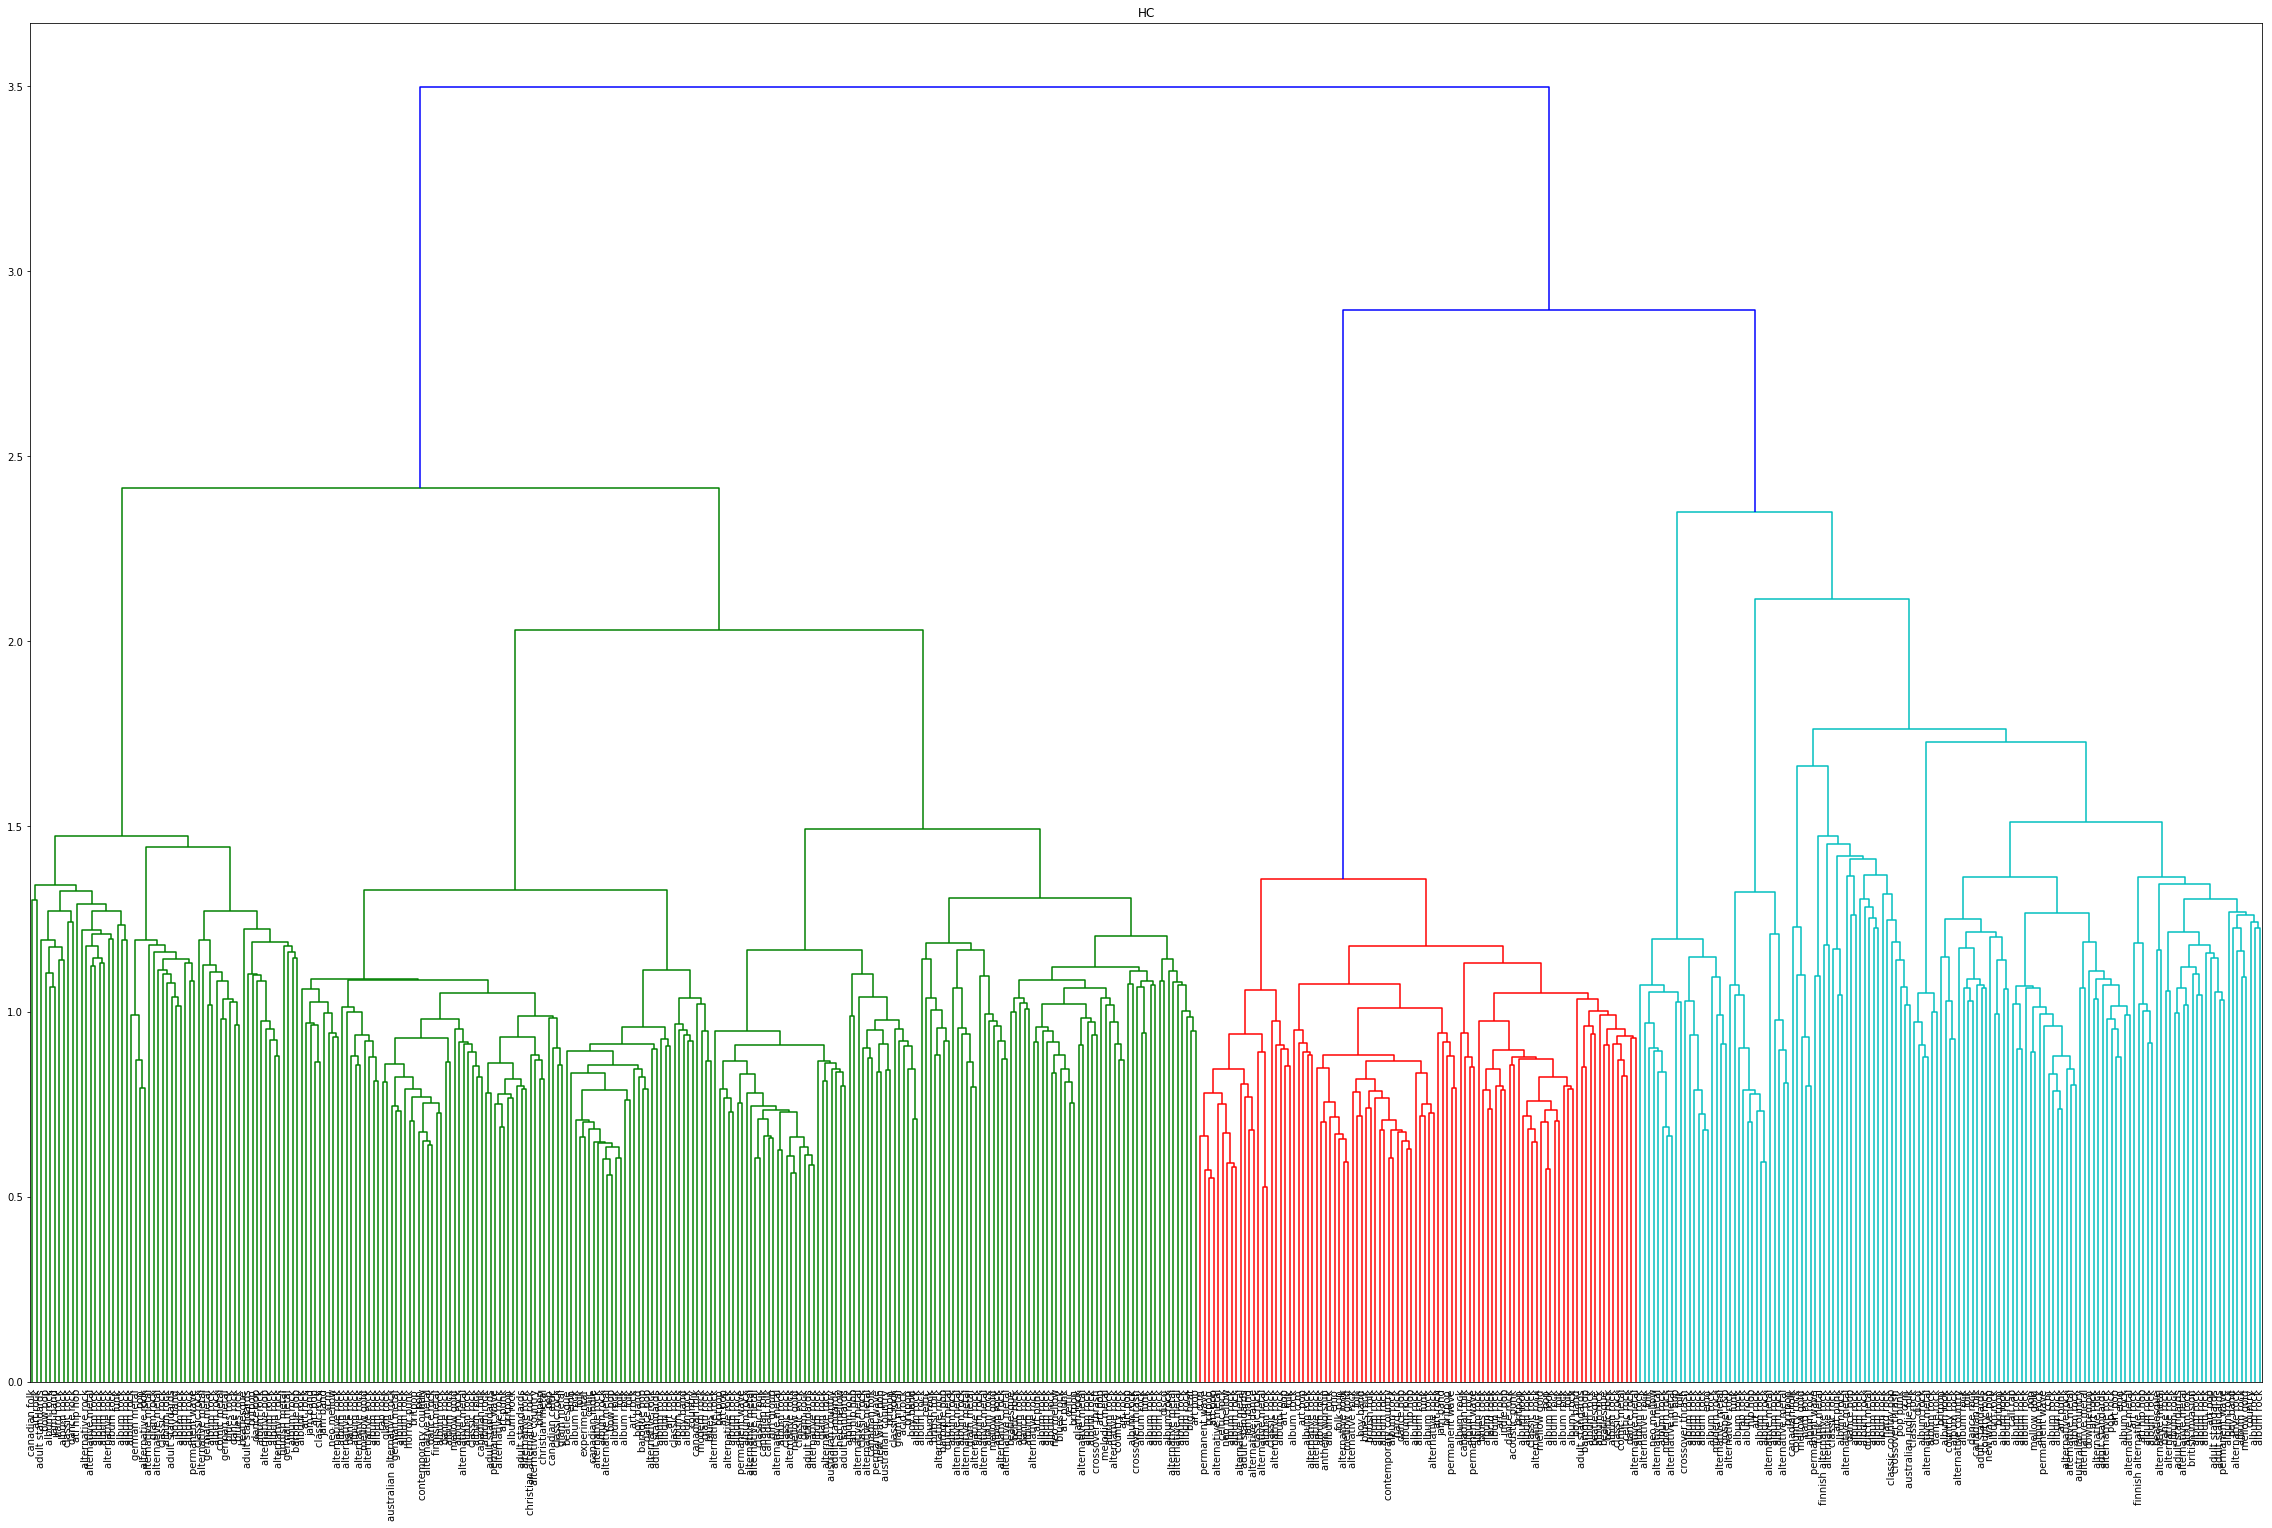

In [63]:
dfs_cleans = df1.sample(frac=0.8)
tf_idf_array = tfidf(dfs_cleans.text)

model = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(tf_idf_array)
link_matrix = linkage_matrix(tf_idf_array.shape[0], model.children_, model.distances_)
plt.figure(figsize=(40,25))
plt.title('HC')

h = dendrogram(link_matrix, labels = (df1.genre1.values), leaf_font_size=10, get_leaves=True);
#plt.savefig('HC_all_Genre_artist_samples.png', bbox_inches = "tight")

In [78]:
# h.pop('dcoord', None)

In [94]:
h.keys()

dict_keys(['ivl', 'leaves', 'color_list'])

In [96]:
hc_dict= pd.DataFrame.from_dict(h)

In [116]:
from collections import Counter
hello = Counter(hc_dict[hc_dict.color_list == 'c'].ivl)

In [117]:
from operator import itemgetter
sorted(hello.items(), key=lambda k: -k[1])

[('album rock', 46),
 ('alternative metal', 13),
 ('alternative rock', 8),
 ('adult standards', 5),
 ('dance rock', 4),
 ('folk', 3),
 ('art rock', 3),
 ('britpop', 3),
 ('country rock', 3),
 ('mellow gold', 3),
 ('permanent wave', 3),
 ('modern rock', 2),
 ('hip hop', 2),
 ('crossover thrash', 2),
 ('emo', 2),
 ('canadian folk', 2),
 ('hard rock', 2),
 ('finnish alternative rock', 2),
 ('classic rock', 2),
 ('art punk', 2),
 ('ccm', 2),
 ('art pop', 2),
 ('neo mellow', 1),
 ('gospel r&b', 1),
 ('funk', 1),
 ('rap rock', 1),
 ('funk metal', 1),
 ('dance pop', 1),
 ('dutch metal', 1),
 ('classic country pop', 1),
 ('pop punk', 1),
 ('australian indie folk', 1),
 ('disco', 1),
 ('alternative country', 1),
 ('new wave pop', 1),
 ('cali rap', 1),
 ('pop', 1),
 ('australian country', 1),
 ('downtempo', 1),
 ('pop rock', 1),
 ('atl hip hop', 1),
 ('beatlesque', 1),
 ('british invasion', 1),
 ('boy band', 1)]

## Gaussian Mixture Model <a name="paragraph3"></a>

#### BIC

In [ ]:
n_components = np.arange(1, 20)
BIC = np.zeros(n_components.shape)
AIC = np.zeros(n_components.shape)

for i, n in enumerate(n_components):
    clf = GaussianMixture(n_components=n,
              covariance_type='tied')
    clf.fit(tf_idf_array)

    AIC[i] = clf.aic(tf_idf_array)
    BIC[i] = clf.bic(tf_idf_array)

plt.figure(figsize=(15,15))
plt.plot(n_components, AIC, label='AIC')
plt.plot(n_components, BIC, label='BIC')
plt.legend(loc=0)
plt.xlabel('n_components')
plt.ylabel('AIC / BIC')
plt.savefig('GMM_BIC_4Genre_tied')

#### hard clustering

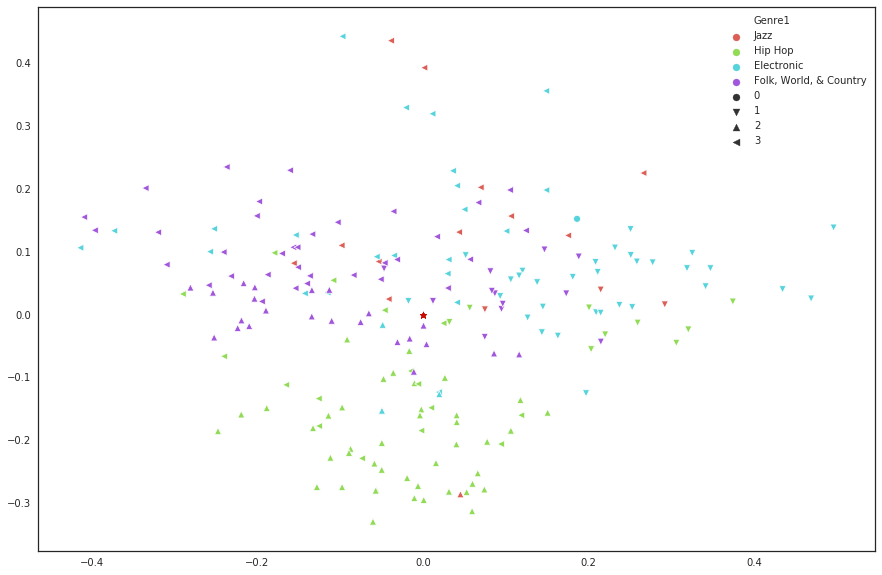

In [91]:
gmm = GaussianMixture(n_components=4, n_init=10, covariance_type='spherical').fit(tf_idf_array)
prediction = gmm.predict(tf_idf_array)
Y = compute_PCA(tf_idf_array)
plt.figure(figsize=(15,10))

# detect anomalies
densities = gmm.score_samples(tf_idf_array)
density_threshold = np.percentile(densities, 4)
anomalies = tf_idf_array[densities < density_threshold]

markers = ('o', 'v', '^', '<', '>', 's', 'p','8', '*', 'h', 'H', 'D', 'd', 'P', 'X', 'o', 'v', '^')
sns.scatterplot(Y[:, 0], Y[:, 1],hue=fourgenres.Genre1, style=prediction, markers=markers,palette=sns.color_palette("hls", len(np.unique(prediction))))
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
# plt.savefig('GMM_images/gmm_altdanc_diag_POS+types')

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 209 samples in 0.006s...
[t-SNE] Computed neighbors for 209 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 209 / 209
[t-SNE] Mean sigma: 0.170580
[t-SNE] Computed conditional probabilities in 0.044s
[t-SNE] Iteration 50: error = 45.4676056, gradient norm = 0.0000000 (50 iterations in 0.139s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 45.467606
[t-SNE] Iteration 100: error = 0.4512766, gradient norm = 0.0052730 (50 iterations in 0.069s)
[t-SNE] Iteration 150: error = 0.4275256, gradient norm = 0.0008303 (50 iterations in 0.035s)
[t-SNE] Iteration 200: error = 0.4220678, gradient norm = 0.0004192 (50 iterations in 0.038s)
[t-SNE] Iteration 250: error = 0.4218281, gradient norm = 0.0001673 (50 iterations in 0.035s)
[t-SNE] Iteration 300: error = 0.4203659, gradient norm = 0.0002483 (50 iterations in 0.037s)
[t-SNE] Iteration

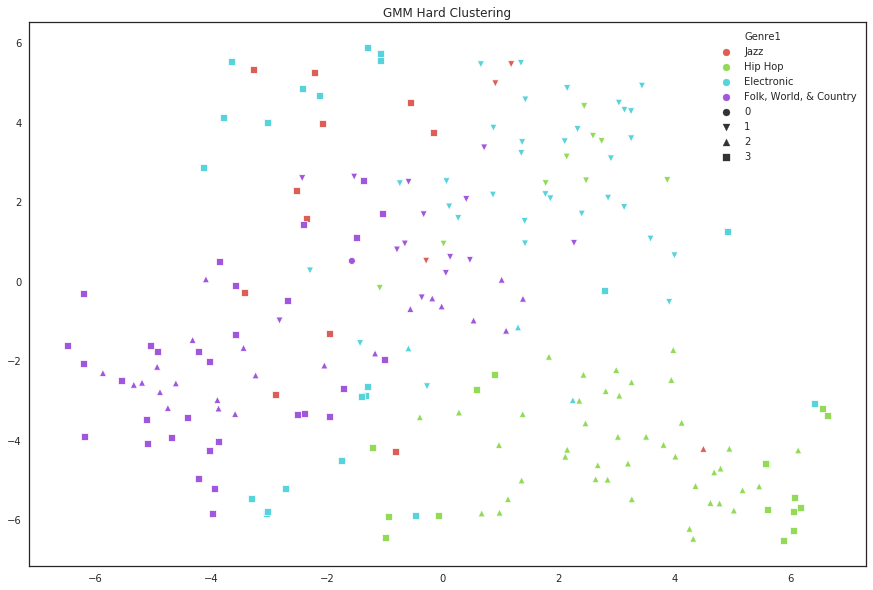

In [90]:
visualise_TSNE(tf_idf_array, fourgenres.Genre1, prediction,'GMM Hard Clustering','GMM_images/gmm_altdanc_diag_POS+types')

In [24]:
print(gmm.means_)
print('\n')
print(gmm.covariances_)

[[0.00041298 0.00088314 0.00049773 ... 0.00017537 0.0002601  0.00015398]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


[1.82025728e-05 1.00000000e-06 1.00000000e-06 1.00000000e-06]


#### soft clustering

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]]
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 209 samples in 0.000s...
[t-SNE] Computed neighbors for 209 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 209 / 209
[t-SNE] Mean sigma: 0.170580
[t-SNE] Computed conditional probabilities in 0.023s
[t-SNE] Iteration 50: error = 45.4676094, gradient norm = 0.0000000 (50 iterations in 0.147s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 45.467609
[t-SNE] Iteration 100: error = 0.4732353, gradient norm = 0.0058645 (50 iterations in 0.063s)
[t-SNE] Iteration 150: error = 0.4349310, gradient norm = 0.0011423 (50 iterations in 0.038s)
[t-SNE] Iteration 200: error = 0.4251957, gradient norm = 0.0003787 (50 iterations in 0.036s)
[t-SNE] Iteration 250: error = 0.4246077, gradient norm = 0.0001354 (50 iterations in 0.035s)
[t-SNE] Iteration 300: error = 0.42

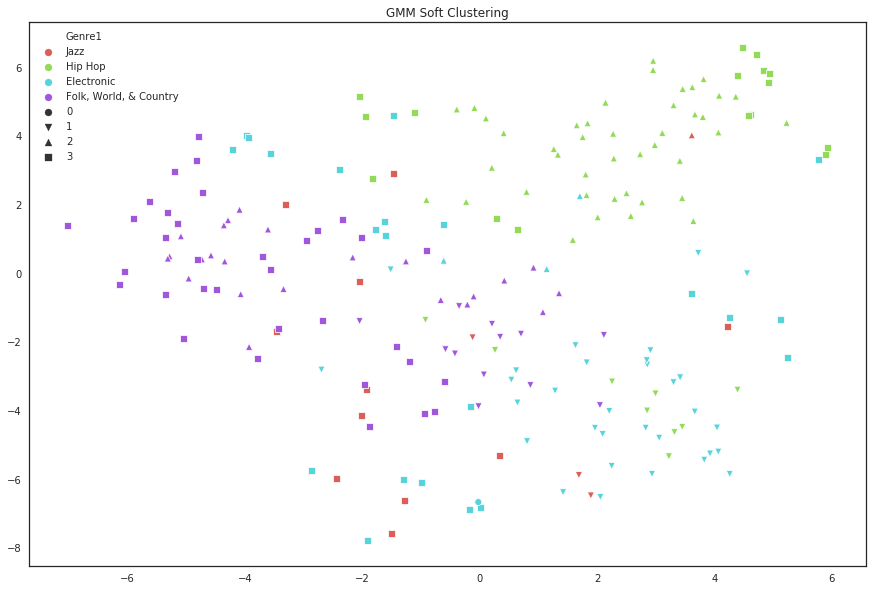

In [92]:
probs = gmm.predict_proba(tf_idf_array)
print(probs[:5])
size = 50 * probs.max(1) ** 2  # square emphasizes differences

visualise_TSNE(tf_idf_array, fourgenres.Genre1, prediction,'GMM Soft Clustering','../images/Bilder_Abschlusspräsi/gmm_twenties_soft_spherical')

In [34]:
# Außreißer mit Wahrscheinlichkeitszuordnungen
d = {'artist': twenty.artist, 'genre': twenty.Genre1, 'decade':twenty.decades}
dat = pd.DataFrame(data=d)
dat = dat.reset_index()
p = pd.DataFrame(data=probs)
probabilities = dat.join(p, how='outer')
probabilities.drop('index', axis=1, inplace=True)
probabilities.columns = ['artist', 'genre', 'decade', '0','1','2','3']
# pr = probabilities[probabilities.iloc[:, probabilities.columns.get_loc('0','3')!= 0.0]]
pr = probabilities[probabilities.iloc[:, probabilities.columns.get_loc('0')]!= 1.0]
pr = pr[pr.iloc[:, pr.columns.get_loc('0')]!= 0.0]
pro = probabilities[probabilities.iloc[:, probabilities.columns.get_loc('1')]!= 1.0]
pro = pro[pro.iloc[:, pro.columns.get_loc('1')]!= 0.0]
prob = probabilities[probabilities.iloc[:, probabilities.columns.get_loc('2')]!= 1.0]
prob = prob[prob.iloc[:, prob.columns.get_loc('2')]!= 0.0]
proba = probabilities[probabilities.iloc[:, probabilities.columns.get_loc('3')]!= 1.0]
proba = proba[proba.iloc[:, proba.columns.get_loc('3')]!= 0.0]
# probab = probabilities[probabilities.iloc[:, probabilities.columns.get_loc('4')]!= 1.0]
# probab = probab[probab.iloc[:, probab.columns.get_loc('3')]!= 0.0]
probability = pd.concat([pr, pro, prob, proba])
probability

,artist,genre,decade,0,1,2,3
54,Fall Out Boy,Rock,2000s,0.0,1.328060e-127,1.000000e+00,0.000000e+00
91,Jackson Browne,Rock,2000s,0.0,1.605886e-175,1.000000e+00,0.000000e+00
145,Ms. Lauryn Hill,Hip Hop,2000s,0.0,3.265538e-302,1.000000e+00,0.000000e+00
156,Nine Inch Nails,Electronic,2000s,0.0,9.129822e-24,1.000000e+00,0.000000e+00
191,Reba McEntire,"Folk, World, & Country",2000s,0.0,1.819207e-110,1.000000e+00,0.000000e+00
195,Robbie Williams,Pop,2000s,0.0,1.787604e-162,1.000000e+00,0.000000e+00
222,The Rolling Stones,Rock,2000s,0.0,3.334479e-200,1.000000e+00,0.000000e+00
229,Tiffany,Rock,2000s,0.0,8.046507e-309,1.000000e+00,0.000000e+00
250,Weezer,Rock,2000s,0.0,1.909938e-32,1.000000e+00,0.000000e+00
29,Culture Club,Electronic,2000s,0.0,0.000000e+00,3.973914e-230,1.000000e+00


In [36]:
probability = probability[probability.genre!='Rock']
probability = probability[probability.genre!='Pop']
probability

,artist,genre,decade,0,1,2,3
145,Ms. Lauryn Hill,Hip Hop,2000s,0.0,3.265538e-302,1.000000e+00,0.000000e+00
156,Nine Inch Nails,Electronic,2000s,0.0,9.129822e-24,1.000000e+00,0.000000e+00
191,Reba McEntire,"Folk, World, & Country",2000s,0.0,1.819207e-110,1.000000e+00,0.000000e+00
29,Culture Club,Electronic,2000s,0.0,0.000000e+00,3.973914e-230,1.000000e+00
73,Hank Williams,"Folk, World, & Country",2000s,0.0,0.000000e+00,1.994558e-218,1.000000e+00
88,Insane Clown Posse,Hip Hop,2000s,0.0,0.000000e+00,7.066848e-280,1.000000e+00
183,Q-Tip,Hip Hop,2000s,0.0,0.000000e+00,1.780805e-214,1.000000e+00
230,Tim McGraw,"Folk, World, & Country",2000s,0.0,1.000000e+00,4.653551e-288,0.000000e+00
32,David Guetta,Electronic,2000s,0.0,0.000000e+00,1.000000e+00,3.953938e-288
35,Dolly Parton,"Folk, World, & Country",2000s,0.0,0.000000e+00,1.000000e+00,8.576813e-188


In [35]:
probabilities

,artist,genre,decade,0,1,2,3
0,"""Weird Al"" Yankovic",Rock,2000s,0.0,0.0,0.0,1.0
1,*NSYNC,Electronic,2000s,0.0,1.0,0.0,0.0
2,Adam Sandler,Rock,2000s,0.0,0.0,0.0,1.0
3,Adele,Pop,2000s,0.0,1.0,0.0,0.0
4,Aerosmith,Rock,2000s,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
271,Yung Joc,Hip Hop,2000s,1.0,0.0,0.0,0.0
272,Z-Ro,Hip Hop,2000s,1.0,0.0,0.0,0.0
273,Zac Brown Band,"Folk, World, & Country",2000s,0.0,0.0,0.0,1.0
274,Zero 7,Rock,2000s,0.0,1.0,0.0,0.0


## Bayes GMM <a name="paragraph4"></a>

https://www.geeksforgeeks.org/ml-variational-bayesian-inference-for-gaussian-mixture/

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 209 samples in 0.002s...
[t-SNE] Computed neighbors for 209 samples in 0.030s...
[t-SNE] Computed conditional probabilities for sample 209 / 209
[t-SNE] Mean sigma: 0.170580
[t-SNE] Computed conditional probabilities in 0.043s
[t-SNE] Iteration 50: error = 45.4676056, gradient norm = 0.0000000 (50 iterations in 0.096s)
[t-SNE] Iteration 50: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 50 iterations with early exaggeration: 45.467606
[t-SNE] Iteration 100: error = 0.4399014, gradient norm = 0.0047054 (50 iterations in 0.065s)
[t-SNE] Iteration 150: error = 0.4185233, gradient norm = 0.0008484 (50 iterations in 0.052s)
[t-SNE] Iteration 200: error = 0.4164234, gradient norm = 0.0004285 (50 iterations in 0.046s)
[t-SNE] Iteration 250: error = 0.4149002, gradient norm = 0.0004644 (50 iterations in 0.053s)
[t-SNE] Iteration 300: error = 0.4146481, gradient norm = 0.0000979 (50 iterations in 0.087s)
[t-SNE] Iteration

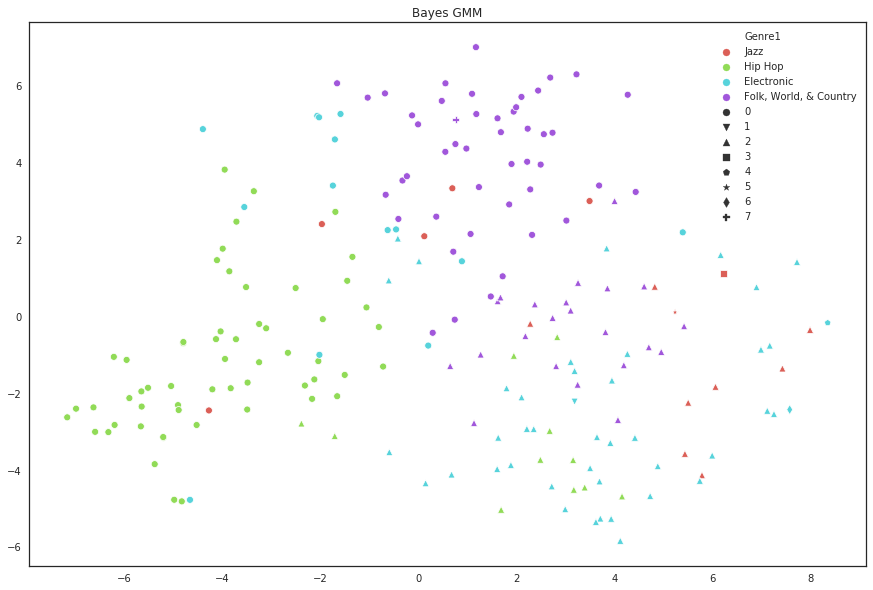

In [93]:
bgmm = BayesianGaussianMixture(n_components=8, n_init=10, covariance_type ='diag').fit(tf_idf_array) 
Y = compute_PCA(tf_idf_array)

prediction = bgmm.predict(tf_idf_array) 
# print((prediction)) 

visualise_TSNE(Y, fourgenres.Genre1, prediction, 'Bayes GMM', 'GMM_images/bgmm_popartist_diag')

In [18]:
 np.round(bgmm.weights_, 2)

array([0.01, 0.  , 0.31, 0.03, 0.63, 0.01, 0.01, 0.  ])

In [62]:
bgmm.converged_

True

#### Kernel PCA

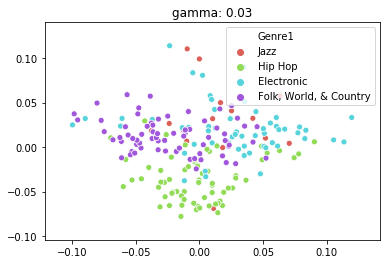

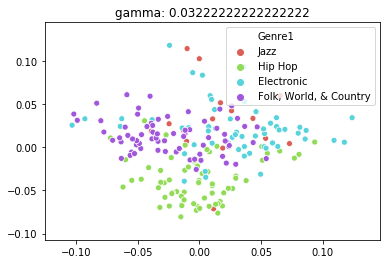

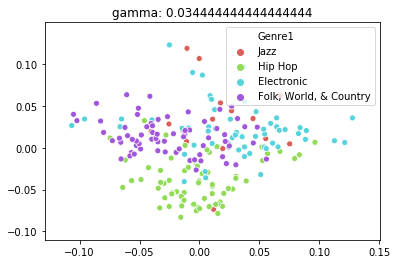

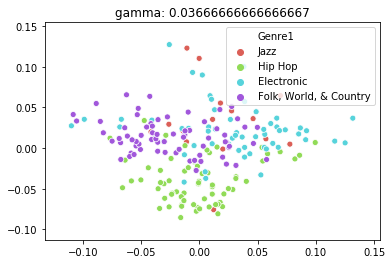

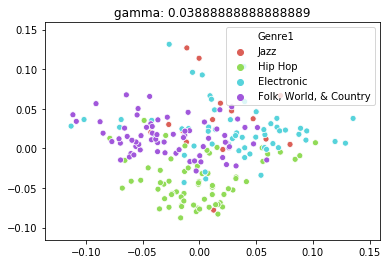

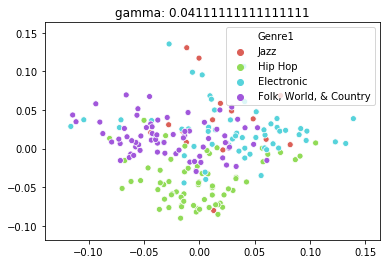

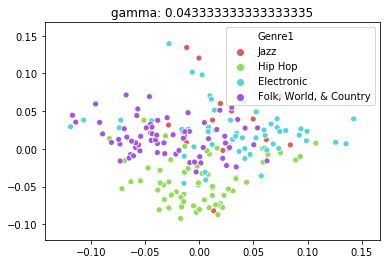

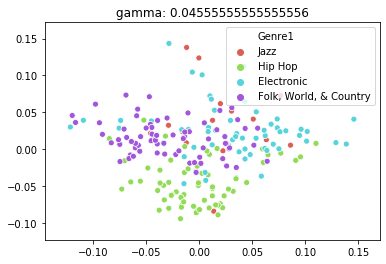

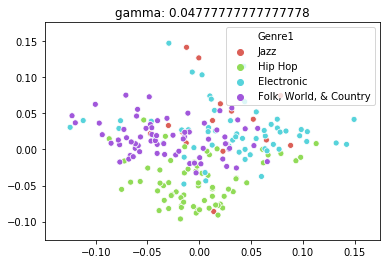

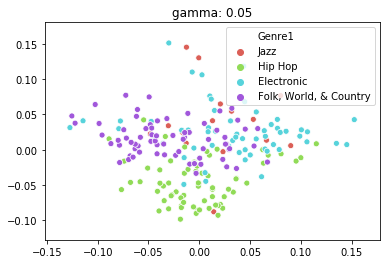

In [19]:
from sklearn.decomposition import KernelPCA
kpca_gamma = np.linspace(0.03, 0.05, 10)
for k in kpca_gamma:
    plt.clf()
    rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=k)
    Y = rbf_pca.fit_transform(tf_idf_array)
    sns.scatterplot(Y[:, 0], Y[:, 1],hue=data.Genre1, palette=sns.color_palette("hls", len(np.unique(data.Genre1))))
    plt.title('gamma: '+ str(k))
    plt.show()

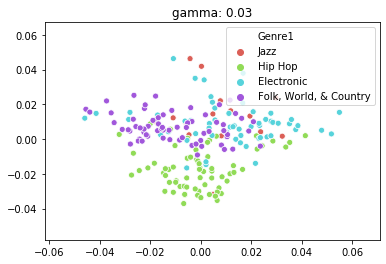

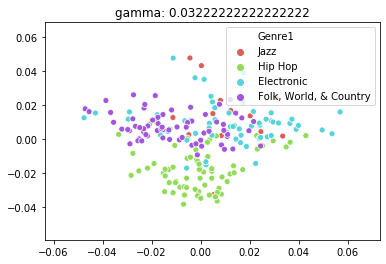

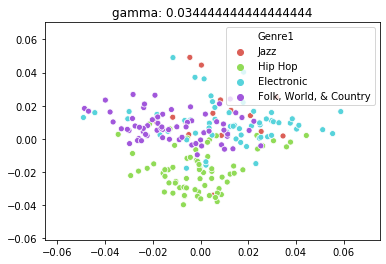

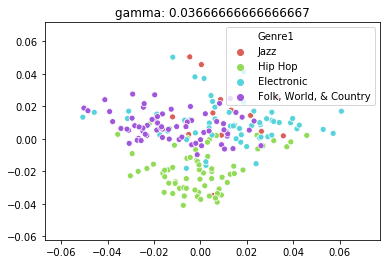

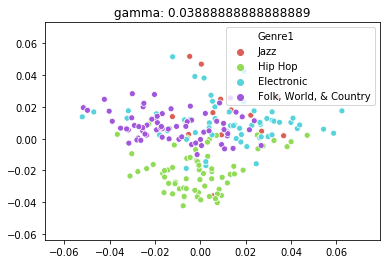

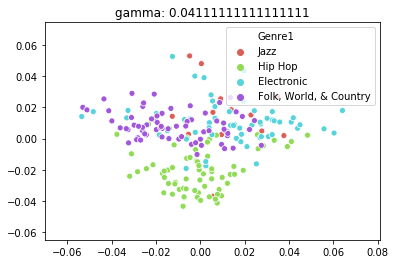

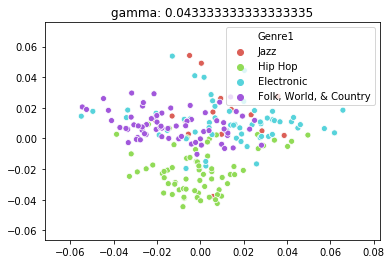

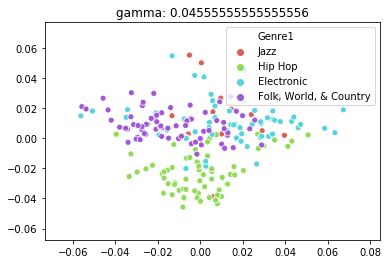

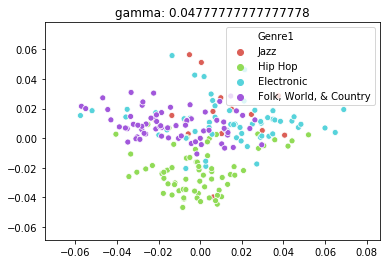

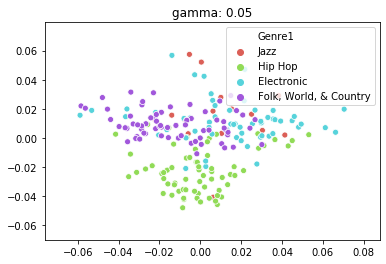

In [20]:
for k in kpca_gamma:
    plt.clf()
    sigmoid_pca = KernelPCA(n_components=2, kernel='sigmoid', gamma=k)
    Y = sigmoid_pca.fit_transform(tf_idf_array)
    sns.scatterplot(Y[:, 0], Y[:, 1],hue=data.Genre1, palette=sns.color_palette("hls", len(np.unique(data.Genre1))))
    plt.title('gamma: '+str(k))
    plt.show()

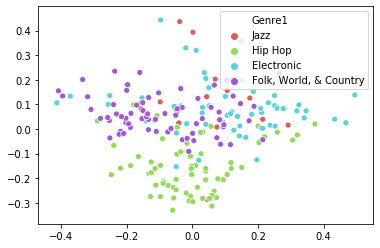

In [21]:
Y = compute_PCA(tf_idf_array)
sns.scatterplot(Y[:, 0], Y[:, 1],hue=data.Genre1, palette=sns.color_palette("hls", len(np.unique(data.Genre1))))

#### Locally Linear Embedding

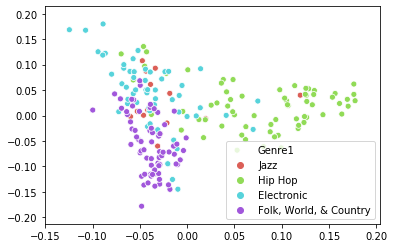

In [23]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=50)
Y = lle.fit_transform(tf_idf_array)
sns.scatterplot(Y[:, 0], Y[:, 1],hue=data.Genre1, palette=sns.color_palette("hls", len(np.unique(data.Genre1))))